In [1]:
# https://www.kaggle.com/docs/api Можно по этой доке загружать датасеты, нужно создать ключ и перенести его в нужную деррикторию
# Есть видео с гайд
!pip install kaggle

In [46]:
from kaggle.api.kaggle_api_extended import KaggleApi


from zipfile import ZipFile

In [ ]:
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [8]:
!kaggle competitions download -c ghouls-goblins-and-ghosts-train


  0%|          | 0.00/38.0k [00:00<?, ?B/s]
100%|##########| 38.0k/38.0k [00:00<00:00, 5.57MB/s]


In [49]:
zip_file = ZipFile('ghouls-goblins-and-ghosts-train.zip')
print('Выводим все файлы , которые есть в zip архиве... ')
print([i.filename for i in zip_file.infolist()])
pd.read_csv(zip_file.open('train.csv.zip'), compression='zip')

Выводим все файлы , которые есть в zip архиве... 
['sample_submission.csv.zip', 'test.csv.zip', 'train.csv.zip']


,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost
...,...,...,...,...,...,...,...
366,886,0.458132,0.391760,0.660590,0.635689,blue,Goblin
367,889,0.331936,0.564836,0.539216,0.551471,green,Ghost
368,890,0.481640,0.501147,0.496446,0.544003,clear,Ghoul
369,896,0.294943,0.771286,0.583503,0.300618,clear,Ghost


#### https://www.kaggle.com/mrtgocer/from-zero-to-hero-lightgbm-classifier
Вот эта интересная визуализация, но тебе стоит посмотреть ещё ноутбуки, мне казалось, там было что-то крутое, но я пока что не нашёл

In [2]:
train = pd.read_csv('/Users/irak/Documents/py_viz/ghouls-goblins-and-ghosts-train/train.csv.zip')

id - id of the creature

bone_length - average length of bone in the creature, normalized between 0 and 1

rotting_flesh - percentage of rotting flesh in the creature

hair_length - average hair length, normalized between 0 and 1

has_soul - percentage of soul in the creature

color - dominant color of the creature: 'white','black','clear','blue','green','blood'

type - target variable: 'Ghost', 'Goblin', and 'Ghoul'

In [8]:
train

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost
...,...,...,...,...,...,...,...
366,886,0.458132,0.391760,0.660590,0.635689,blue,Goblin
367,889,0.331936,0.564836,0.539216,0.551471,green,Ghost
368,890,0.481640,0.501147,0.496446,0.544003,clear,Ghoul
369,896,0.294943,0.771286,0.583503,0.300618,clear,Ghost


In [7]:
train.describe()

,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


In [71]:
# https://stackoverflow.com/questions/30942577/seaborn-correlation-coefficient-on-pairgrid
def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    from scipy.stats import pearsonr
    import matplotlib.pyplot as plt 
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

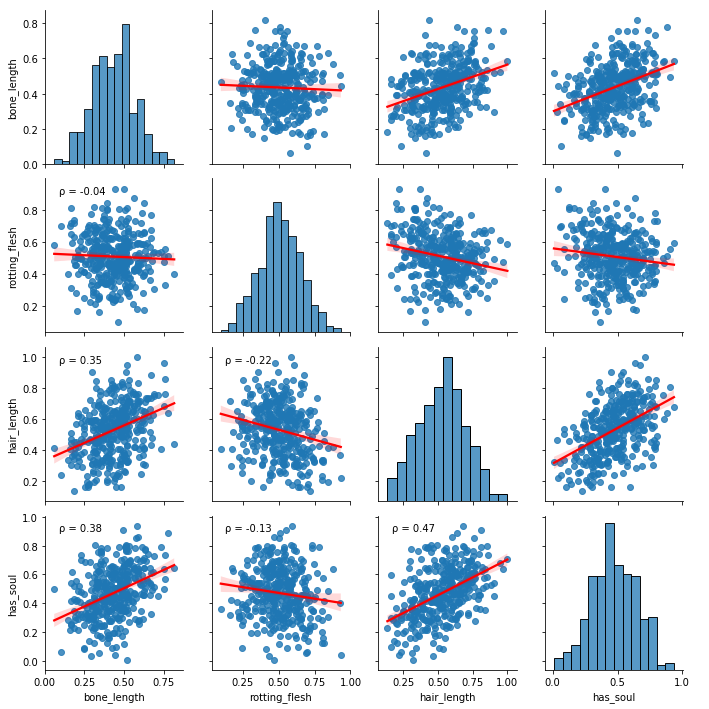

In [92]:
# scatter_matrix(train, alpha=1, s=5, c = 'black', figsize=(6, 6), diagonal="kde");
g = sns.pairplot(train.iloc[:,1:], kind="reg", plot_kws={'line_kws':{'color':'red'}})
g.map_lower(corrfunc)

In [91]:
train

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost
...,...,...,...,...,...,...,...
366,886,0.458132,0.391760,0.660590,0.635689,blue,Goblin
367,889,0.331936,0.564836,0.539216,0.551471,green,Ghost
368,890,0.481640,0.501147,0.496446,0.544003,clear,Ghoul
369,896,0.294943,0.771286,0.583503,0.300618,clear,Ghost


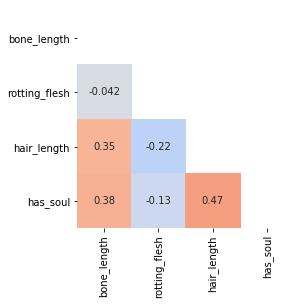

In [111]:
corr = train.iloc[:, 1:-2].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', cbar=False, square=True)

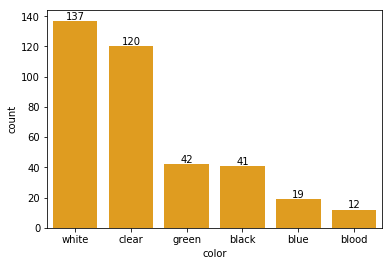

In [127]:
ax = sns.countplot(x="color", data=train, order = train['color'].value_counts().index, color = 'orange')
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+1), ha='center')

In [114]:
train['type'].value_counts()

Ghoul     129
Goblin    125
Ghost     117
Name: type, dtype: int64

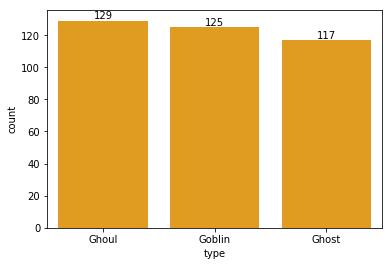

In [120]:
ax = sns.countplot(x="type", data=train, order = train['type'].value_counts().index, color = 'orange')
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+1), ha = 'center')
# train['type'].value_counts().plot(kind="bar")

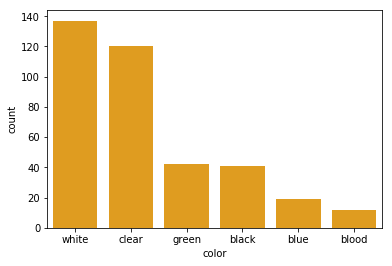

In [138]:
for t in train['type'].unique():
    ax = sns.countplot(x="color", data=train, order = train['color'].value_counts().index, color = 'orange')

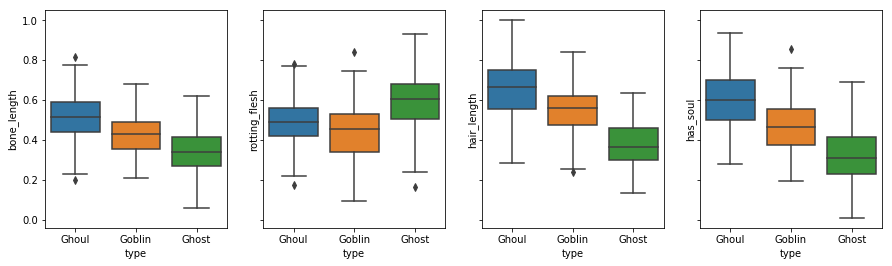

In [209]:
fig, ax = plt.subplots(1, 4, sharex = True, sharey = True, figsize=(15, 4))
n = 0
for c in train.iloc[:, 1:-2].columns:
    sns.boxplot(ax=ax[n], x = train['type'], y=train[c])
    n+=1


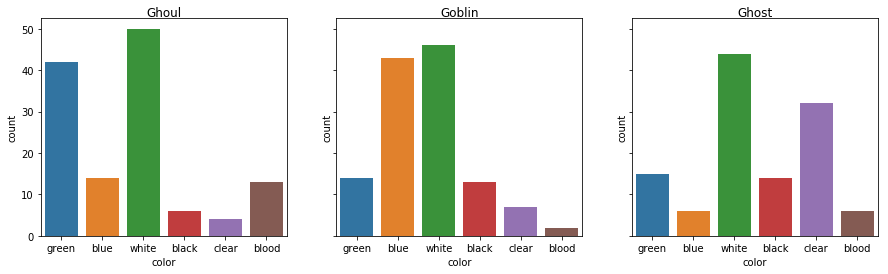

In [225]:
fig, ax = plt.subplots(1, 3, sharex = True, sharey = True, figsize=(15, 4))
n = 0
for c in train['type'].unique():
    sns.countplot(ax=ax[n], x = train[train['type'] == c]['color'])
    ax[n].set_title(c, pad = 2)
    n+=1

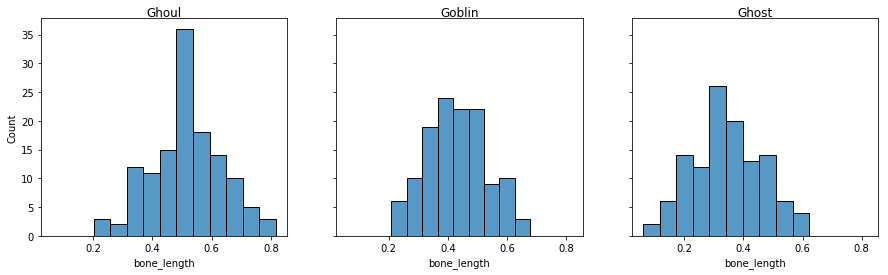

In [226]:
fig, ax = plt.subplots(1, 3, sharex = True, sharey = True, figsize=(15, 4))
n = 0
for c in train['type'].unique():
    sns.histplot(ax=ax[n], x = train[train['type'] == c]['bone_length'])
    ax[n].set_title(c, pad = 2)
    n+=1